[Reference](https://levelup.gitconnected.com/five-useful-pandas-scripts-for-financial-time-series-plots-99693c4025b2)

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 11.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


[*********************100%***********************]  1 of 1 completed


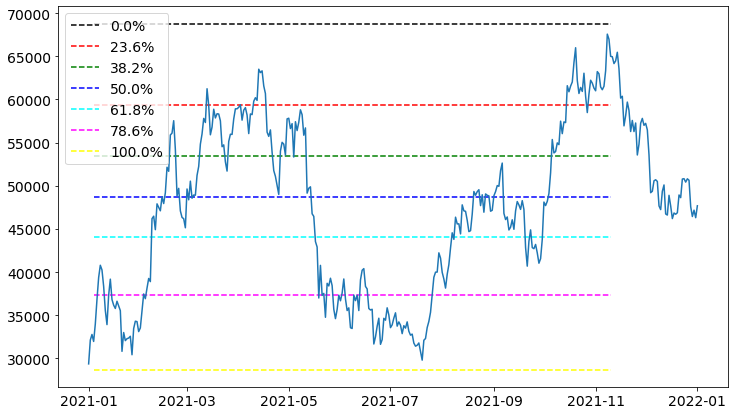

In [3]:
import pandas as pd
from pandas import DataFrame

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def get_correlation(df:DataFrame, column1:str, column2:str) -> float:
    """
    Calculates the correlation between two columns in a dataframe.
    :param df: The dataframe containing the columns.
    :param column1: The first column.
    :param column2: The second column.
    :return: The correlation between the two columns.
    """
    return df[column1].corr(df[column2])

def get_lagging_correlation(df:DataFrame, column1:str, column2:str, lag: int) -> float:
    """
    Calculates the correlation between two columns in a dataframe with certain lag
    :param df: The dataframe containing the columns.
    :param column1: The first column.
    :param column2: The lagging column.
    :return: The correlation between the two columns.
    """
    return df[column1].corr(df[column2].shift(lag))

def impute_values_with_linear_regression(df:DataFrame, column: str) -> pd.Series:
    """
    Fills NaN values using linear regression interpolation.
    :param df: The dataframe containing the column.
    :param column: The column to be imputed.
    :return: The dataframe with the imputed values.
    """
    return df[column].interpolate()

def get_relative_strength_index(df:DataFrame, column:str, periods:int) -> pd.DataFrame:
    """
    Returns the Relative Strength Index for a given column in a dataframe.
    """
    close_delta = df[column].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        
    rs = ma_up / ma_down
    df['{}_rsi'.format(column)] = 100 - (100/(1 + rs))
    
    return df

def get_bollinger_bands(df:DataFrame, column:str, period:int, std_dev:float) -> pd.DataFrame:
    """
    Calculates the Bollinger Bands for a given column in a dataframe.
    :param df: The dataframe containing the column.
    :param column: The column to be used.
    :param period: The period to be used.
    :return: The dataframe with the Bollinger Bands columns.
    """

    df['{}_upper_band'.format(column)] = df[column].rolling(period).mean() + (df[column].rolling(period).std() * std_dev)
    df['{}_lower_band'.format(column)] = df[column].rolling(period).mean() - (df[column].rolling(period).std() * std_dev)
    return df

def get_macd(df:DataFrame, column:str, period1:int, period2:int, period3:int) -> DataFrame:
    """
    Calculates the MACD for a given column in a dataframe.
    :param df: The dataframe containing the column.
    :param column: The column to be used.
    :param period1: The first period to be used.
    :param period2: The second period to be used.
    :param period3: The third period to be used.
    """

    df['{}_macd'.format(column)] = df[column].ewm(span=period1).mean() - df[column].ewm(span=period2).mean()
    df['{}_signal'.format(column)] = df['{}_macd'.format(column)].ewm(span=period3).mean()
    return df

def get_exponential_moving_average_over_period(df:DataFrame, column:str, period:int) -> pd.Series:
    """
    Calculates the exponential moving average over a given period.
    :param df: The dataframe containing the column.
    :param column: The column to be used.
    :param period: The period to be used.
    :return: The series with the moving average column.
    
    """
    return df[column].ewm(span=period, adjust=False).mean()

def calculate_annual_return_percentage(starting_value, ending_value, period):
    """
    Calculates the annual return percentage.
    :param starting_value: The starting value.
    :param ending_value: The ending value.
    :param period: The period.
    :return: The annual return percentage.
    """
    if period <= 0:
        raise ValueError("Period must be greater than 0")

    return_value = (ending_value - starting_value) / starting_value
    return (1 + return_value) ** (1 / period) - 1

def get_log_returns(df, column):
    """
    Calculates the log returns for a given column in a dataframe.
    :param df: The dataframe containing the column.
    :param column: The column to be used.
    :return: The series with the log returns column.
    """
    returns = np.log(df[column]/df[column].shift(1))
    return returns.fillna(0, inplace=True)
    
def calculate_volatility(df, periods, column):
    """
    Calculates the volatility for a given column in a dataframe.
    
    df: The dataframe containing the column.
    periods: The periods to be used.
    column: The column to be used.
    :return: The volatility series column and mean volatility.
    """
    returns = get_log_returns(df, column)

    volatility_series = returns.rolling(window=periods).std() * np.sqrt(periods)

    return volatility_series, volatility_series.mean()

def get_sharpe_ratio(df, periods, column):
    """
    Calculates the Sharpe ratio for a given column in a dataframe.
    :param df: The dataframe containing the column.
    :param periods: The periods to be used.
    :param column: The column to be used.
    :return: The Sharpe ratio.
    """
    returns = get_log_returns(df, column)
    volatility = calculate_volatility(df, periods, column)[0]

    return returns.mean()/volatility

def plot_bollinger_bands(df, column, period, std_dev):
    """
    Plots the Bollinger Bands for a given column in a dataframe.
    """
    df = get_bollinger_bands(df, column, period, std_dev)
    df.plot()
    plt.show()

def plot_macd(df, column, period1, period2, period3):
    """
    Plots the MACD for a given column in a dataframe.
    """
    df = get_macd(df, column, period1, period2, period3)
    df.plot()
    plt.show()

def plot_rsi(df, column, periods):
    """
    Plots the RSI for a given column in a dataframe.
    """
    df = get_relative_strength_index(df, column, periods)
    df.plot()
    plt.show()

def plot_against_benchmark(series, benchmark):
    """
    Plots a series against a benchmark.
    :param series: The series to be plotted.
    :param benchmark: The benchmark to be plotted.
    :return: The plot.
    """

    ax1 = series.plot(label=series.name, color='blue')
    benchmark.plot(label=benchmark.name, color='red', ax=ax1)

    ax1.show()

def plot_autocorrelation(series):
    """
    Plots the autocorrelation of a series.
    :param series: The series to be plotted.
    :return: The plot.
    """

    ax1 = series.autocorr().plot(label=series.name, color='blue')

    ax1.show()

def plot_std_dev(series):
    """
    Plots the standard deviation of a series.
    :param series: The series to be plotted.
    :return: The plot.
    """
    mean = series.mean()
    std = series.std()

    ax1 = plt.plot(series.index, (series - mean) / std)
    plt.fill_between(
        series.index,
        (series - mean) / std,
        (series - mean) / std,
        color='blue',
        alpha=0.2,
        ax = ax1
    )

    ax1.show()

def plot_fibonacci_retracement(df, output_file = "fibonacci_retracement.png"):
    """
    Plots the Fibonacci retracement of a pricing data.
    :param df: The pricing data.
    :return: The plot.
    """
    highest_swing = -1
    lowest_swing = -1

    for i in range(1,df.shape[0]-1):
        if df['High'][i] > df['High'][i-1] and df['High'][i] > df['High'][i+1] and (highest_swing == -1 or df['High'][i] > df['High'][highest_swing]):
            highest_swing = i
        if df['Low'][i] < df['Low'][i-1] and df['Low'][i] < df['Low'][i+1] and (lowest_swing == -1 or df['Low'][i] < df['Low'][lowest_swing]):
            lowest_swing = i

    ratios = [0,0.236, 0.382, 0.5 , 0.618, 0.786,1]
    colors = ["black","r","g","b","cyan","magenta","yellow"]
    levels = []
    max_level = df['High'][highest_swing]
    min_level = df['Low'][lowest_swing]
    for ratio in ratios:
        if highest_swing > lowest_swing: # Uptrend
            levels.append(max_level - (max_level-min_level)*ratio)
        else: # Downtrend
            levels.append(min_level + (max_level-min_level)*ratio)

    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rc('font', size=14)
    plt.plot(df['Close'])
    start_date = df.index[min(highest_swing,lowest_swing)]
    end_date = df.index[max(highest_swing,lowest_swing)]
    for i in range(len(levels)):
        plt.hlines(levels[i],start_date, end_date,label="{:.1f}%".format(ratios[i]*100),colors=colors[i], linestyles="dashed")
        plt.legend()
    
    plt.savefig(output_file)

if __name__ == '__main__':
    df = yf.download('BTC-USD', start='2021-01-01', end='2022-01-01')

    plot_fibonacci_retracement(df)

# Candlestick


In [4]:
def plot_candlestick(prices, figsize = (13, 10), ax = None):
    """
    Plots the candlestick of a pricing data.
    Credits: https://www.statology.org/matplotlib-python-candlestick-chart/ 
    """
    
    if ax == None:
        ax = plt.figure(figsize = figsize)

    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down prices
    up = prices[prices.Close>=prices.Open]
    down = prices[prices.Close<prices.Open]

    #plot up prices
    plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color='green')
    plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color='green')
    plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color='green')

    #plot down prices
    plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color='red')
    plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color='red')
    plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color='red')

    plt.xlim([df.index.date.min(), df.index.date.max()])
    
    return plt.gcf()

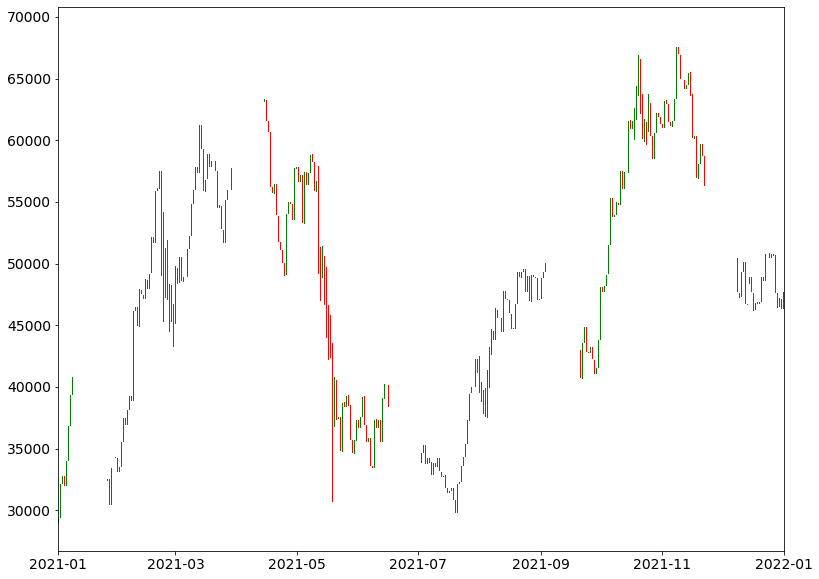

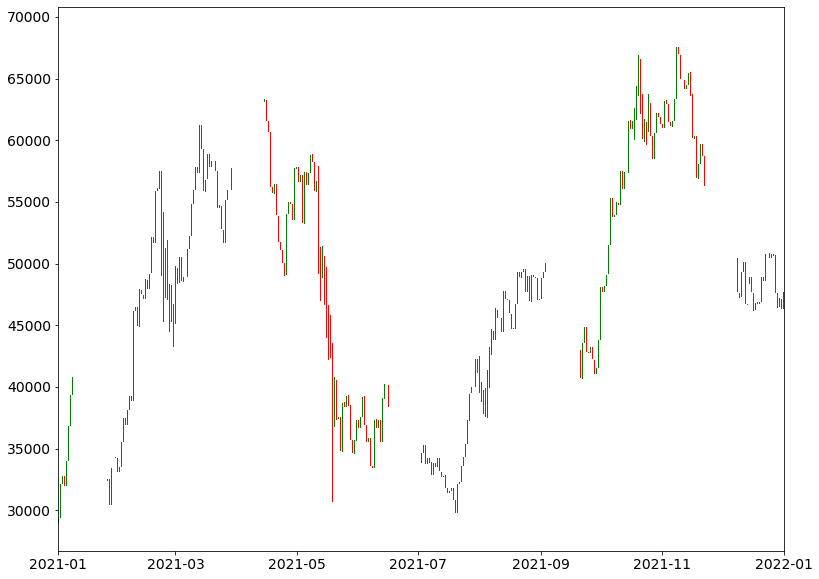

In [7]:
# import datetime
plot_candlestick(df)
# plt.xlim([datetime.date(2022, 1, 1), datetime.date.today()])

# Fibonacci Retracement


In [8]:
def plot_fibonacci_retracement(df):
    """
    Plots the Fibonacci retracement of a pricing data.
    :param df: The pricing data.
    :return: The plot.
    """
    highest_swing = df['High'].idxmax()
    lowest_swing = df['Low'].idxmin()

    ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786, 1]
    colors = ["black","r","g","b","cyan","magenta","yellow"]
    levels = []
    max_level = df['High'][highest_swing]
    min_level = df['Low'][lowest_swing]

    for ratio in ratios:
        if highest_swing > lowest_swing:
            levels.append(max_level - (max_level-min_level)*ratio)
        else:
            levels.append(min_level + (max_level-min_level)*ratio)

    for i in range(len(levels)):
        plt.hlines(levels[i], df.index[0], df.index[-1], label="{:.1f}%".format(ratios[i]*100),colors=colors[i], linestyles="dashed")


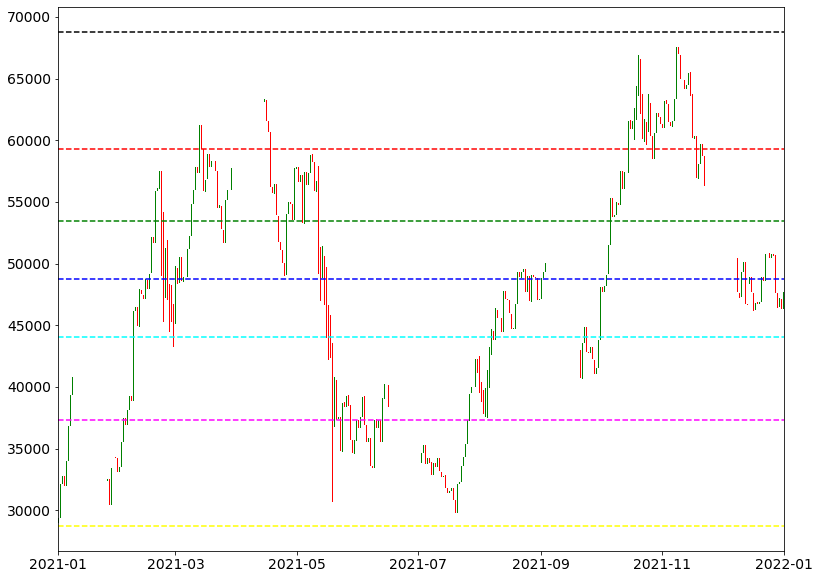

In [9]:
plot_candlestick(df)
plot_fibonacci_retracement(df)

# Benchmark


In [10]:
def plot_against_benchmark(series, benchmark, figsize = (13, 10), two_axis = False):
    """
    Plots a series against a benchmark.
    :param series: The series to be plotted.
    :param benchmark: The benchmark to be plotted.
    :return: The plot.
    """

    plt.figure(figsize = figsize)
    
    ax1 = series.plot(label=series.name, color='blue', legend = True)

    if two_axis:
        ax2 = ax1.twinx()
        ax2.plot(benchmark, label=benchmark.name, color='red')
    else:
        benchmark.plot(label=benchmark.name, color='red', ax=ax1, legend = True)

    return plt.gcf()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


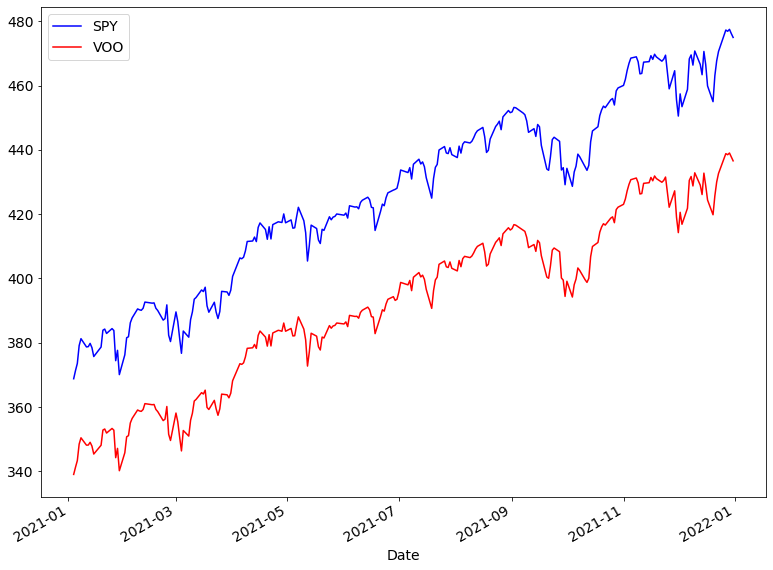

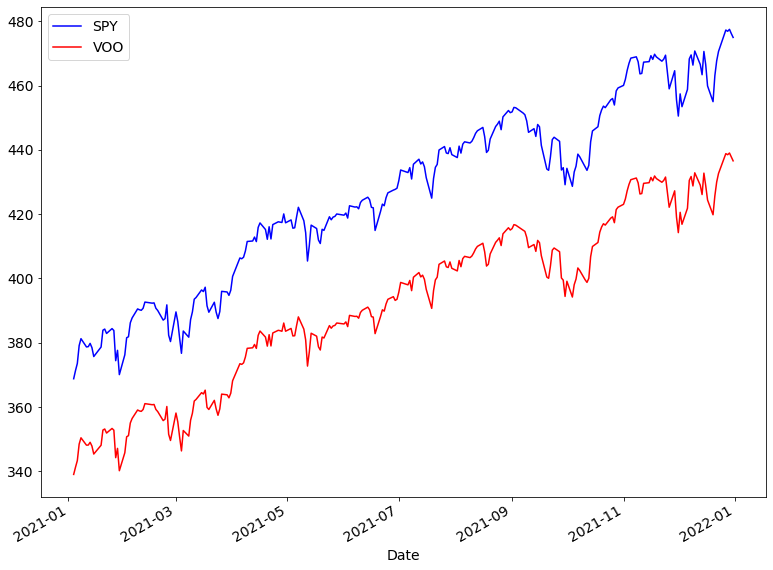

In [19]:
spy = yf.download('SPY', start='2021-01-01', end='2022-01-01')
voo = yf.download('VOO', start='2021-01-01', end='2022-01-01')

spy.rename(columns = {'Close': 'SPY'}, inplace = True)
voo.rename(columns = {'Close': 'VOO'}, inplace = True)
plot_against_benchmark(spy['SPY'], voo['VOO'])

# Volume


In [20]:
def plot_volume(df, aggregation = None, figsize = (13, 10), ax = None):
    """
    Plots the volume of a pricing data.
    """
    if ax == None:
        ax = plt.figure(figsize = figsize)

    if aggregation is not None:
        if aggregation == 'daily':
            df = df.resample('D').sum()
        elif aggregation == 'weekly':
            df = df.resample('W').sum()
        elif aggregation == 'monthly':
            df = df.resample('M').sum()
        elif aggregation == 'quarterly':
            df = df.resample('Q').sum()
        elif aggregation == 'yearly':
            df = df.resample('A').sum()
        else:
            raise ValueError("Invalid aggregation.")

    df = df.reset_index()
    df = df.set_index('Date')
    df = df.sort_index()

    plt.bar(df.index.date, df['Volume'])
    
    return plt.gcf()

<Figure size 864x504 with 0 Axes>

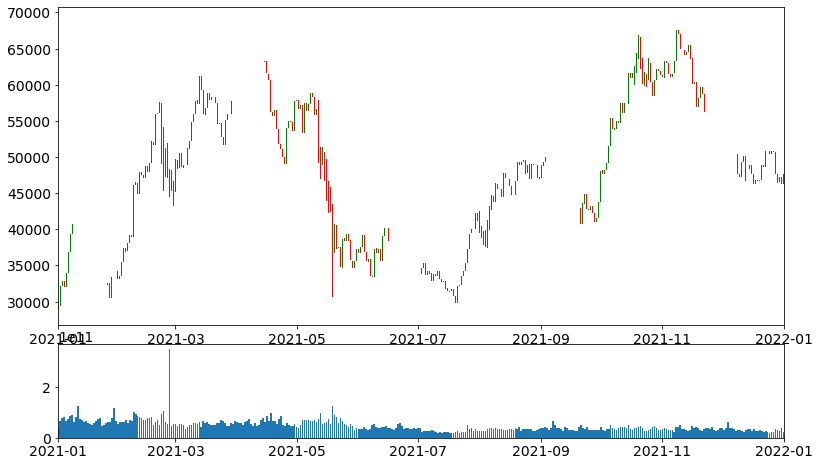

<Figure size 864x504 with 0 Axes>

In [23]:
import datetime
price_plot = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
plot_candlestick(df, ax = price_plot)
volume_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4, sharex = price_plot)
plot_volume(df, aggregation = 'daily', ax = volume_plt)
plt.gcf().set_size_inches(13, 10)
plt.figure()

# Exponential Moving Average


In [24]:
def plot_ewm(df, column, span, figsize = (13, 10), ax = None):
    """
    Plots the exponential moving average of a series.
    """
    plt.figure(figsize=figsize)

    if ax == None:
        ax = plt.gca()

    ewm = get_exponential_moving_average_over_period(df, column, span)
    ax.plot(ewm)
    
    return plt.gcf()

<Figure size 936x720 with 0 Axes>

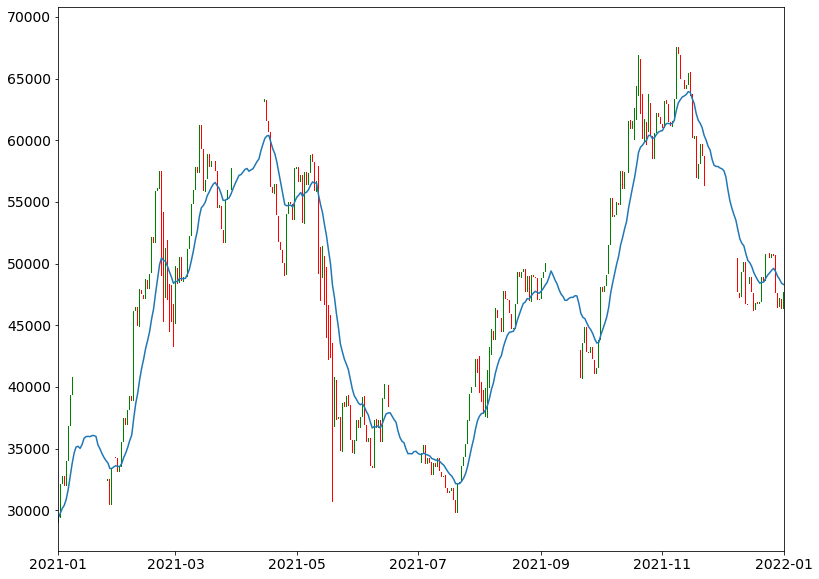

<Figure size 936x720 with 0 Axes>

In [26]:
candle = plot_candlestick(df)
plot_ewm(df, 'Close', 14, ax = candle.gca())